In [1]:
%matplotlib inline

In [2]:
import numpy as np
from numpy import log

from scipy import linalg
from scipy import sparse
from scipy.sparse import csr_matrix

import pandas as pd

import sklearn.metrics.pairwise as knl
from sklearn import datasets
from sklearn.manifold import Isomap
from sklearn.neighbors import kneighbors_graph, radius_neighbors_graph

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
plt.rcParams['figure.figsize'] = [9,5] #globally set figure size
params = {'legend.fontsize': 'x-small',
         'axes.labelsize': 'x-small',
         'axes.titlesize':'x-small',
         'xtick.labelsize':6,
         'ytick.labelsize':6}
plt.rcParams.update(params)

from mpl_toolkits.mplot3d import Axes3D

import tadasets

from ripser import ripser
from persim import plot_diagrams

/home/ag16115/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [4]:
n = 1000 #4000 for surf plots, 1000 for tda plots and 2000 for regression
p = 500
r = 20  #r=20 for plots
sigma = 0 #0 for surf plots,  1 for regression

np.random.seed(123)

In [5]:
#sample uniformly from torus
tor_rad = 0.25
tor_c = 1
Z = tadasets.torus(n,tor_c,a=tor_rad)
color_t1 = np.arctan2(Z[:,0],Z[:,1]) #colour by azimuth about origin
color_t2 = np.arctan2(Z[:,2],-(tor_c-(Z[:,0]**2+Z[:,1]**2)**0.5)) #colour by angle of elevation about center of tube

offset = 0
multiplier = 1
Z[:,0] = multiplier*Z[:,0] + offset


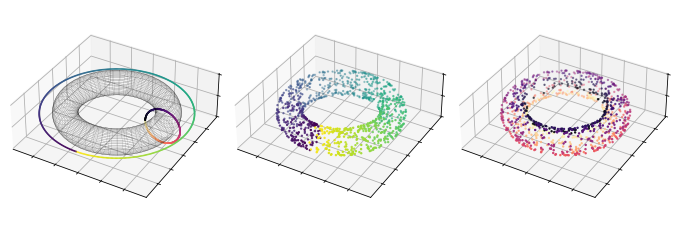

In [14]:
#function for mesh plot of torus
def plot_torus(precision, c, a):
    U = np.linspace(0.2, 2*np.pi, precision)
    V = np.linspace(0, 2*np.pi, precision)
    U, V = np.meshgrid(U, V)
    X = (c+a*np.cos(V))*np.cos(U)
    Y = (c+a*np.cos(V))*np.sin(U)
    Z = a*np.sin(V)
    return X, Y, Z

x, y, z = plot_torus(100, tor_c, tor_rad)

#arrays used for plotting colourbar rings
theta_1 = np.linspace(0, 2*np.pi, 400)
theta_2 = np.linspace(0, 2*np.pi, 400)
circ_1_y = -(tor_c+2*tor_rad)*np.cos(theta_1)
circ_1_x = -(tor_c+2*tor_rad)*np.sin(theta_1)
circ_1_z = np.zeros(400)
circ_2_x = tor_c-1.5*tor_rad*np.cos(theta_2)
circ_2_y = np.zeros(400)
circ_2_z = -1.5*tor_rad*np.sin(theta_2)

#fig = plt.figure()
fig = plt.figure(figsize=(9.5,3.5))
ax = fig.add_subplot(131, projection='3d')

#plot the colormap rings and the wireframe torus
ax.scatter3D(circ_2_x, circ_2_y, circ_2_z, c=cm.magma(np.linspace(1, 0, 400)), s=0.5, alpha=1 )
ax.scatter3D(circ_1_x, circ_1_y, circ_1_z, c=cm.viridis(np.linspace(0, 1, 400)), s=0.5, alpha=1)
ax.plot_wireframe(x, y, z, color = 'k', linewidth = 0.1, alpha=0.8, cstride=2, rstride=2)

ax.set_xlim(-1.4,1.4)
ax.set_ylim(-1.4,1.4)
ax.set_zlim(-0.5,0.5)
ax.set_zticks([-0.5,0,0.5])
ax.tick_params(labelbottom=False, labelleft=False)

ax.elev = 35

world_limits = ax.get_w_lims()
ax.set_box_aspect((world_limits[1]-world_limits[0],world_limits[3]-world_limits[2],world_limits[5]-world_limits[4]))


#now add the sampled points, coloured according their ring coordinates
ax = fig.add_subplot(132, projection='3d')
#ax.set_box_aspect(aspect = (1,1,0.5))
ax.scatter(Z[:,0],Z[:,1],Z[:,2],marker='o',c=color_t1, s=2, cmap='viridis')
ax.set_xlim(-1.4,1.4)
ax.set_ylim(-1.4,1.4)
ax.set_zlim(-0.5,0.5)
ax.set_zlim(-0.5,0.5)
ax.set_zticks([-0.5,0,0.5])
ax.tick_params(labelbottom=False, labelleft=False)
ax.elev = 35

world_limits = ax.get_w_lims()
ax.set_box_aspect((world_limits[1]-world_limits[0],world_limits[3]-world_limits[2],world_limits[5]-world_limits[4]))

ax = fig.add_subplot(133, projection='3d')
ax.scatter(Z[:,0],Z[:,1],Z[:,2],marker='o',c=-color_t2, s=2, cmap='magma')
ax.set_xlim(-1.4,1.4)
ax.set_ylim(-1.4,1.4)
ax.set_zlim(-0.5,0.5)
ax.set_zlim(-0.5,0.5)
ax.set_zticks([-0.5,0,0.5])
ax.tick_params(labelbottom=False, labelleft=False)
ax.elev = 35

world_limits = ax.get_w_lims()
ax.set_box_aspect((world_limits[1]-world_limits[0],world_limits[3]-world_limits[2],world_limits[5]-world_limits[4]))


fig.tight_layout()
# fig.tight_layout()


In [15]:
#plt.savefig('torus_data.png', bbox_inches='tight', pad_inches=0, format='png', dpi=1200)
# plt.savefig('torus_data.png', bbox_inches=matplotlib.transforms.Bbox([[0, 0.5], [9.5, 3]]), pad_inches=0, format='png', dpi=600)

In [16]:
K = knl.rbf_kernel(Z,gamma=1)
#K = knl.sigmoid_kernel(Z)
#K = knl.polynomial_kernel(Z, gamma = 1, coef0=1, degree=3)
#K=knl.laplacian_kernel(Z)

In [17]:
#generate gaussian data and do SVD
    
X = np.random.multivariate_normal(np.zeros(n),K+sigma**2*np.eye(n),size=p)  
  
U, s, Vh = sparse.linalg.svds(X,k=r)

idx = np.argsort(s)
idx = np.flip(idx)
U = U[:,idx]
s = s[idx]
Vh = Vh[idx,:]

In [18]:
print(X.shape)
print(color_t1.shape)

(500, 1000)
(1000,)


In [19]:
# #save the generated data for use in regression experiments
# np.savetxt('torus_covariates_n2k.dat', X.T)
# np.savetxt('torus_responses_n2k.dat', np.vstack([color_t1, color_t2]).T)

[147562.39231633  95112.01257852  84853.79679298  38182.48269388
  34962.4960238   13817.97637864  13374.63907697   9547.12839941
   8102.22861677   6243.6392926    5463.42335601   4409.17753578
   4027.10574422   3607.55898057   3261.05343242   2466.33018148
   2240.60051345   1334.54690396   1128.61359632    943.46197121]


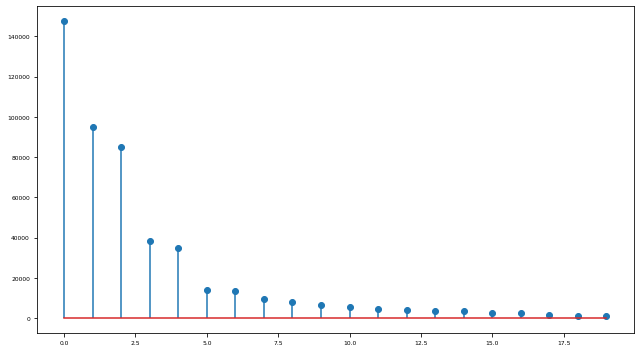

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.stem(s**2)
fig.tight_layout()

print(s**2)

In [21]:
#NB division by square root p as per concentration theorem
zeta = np.diag(s[0:r]) @ Vh[0:r,:] /p**0.5
zeta = zeta.T

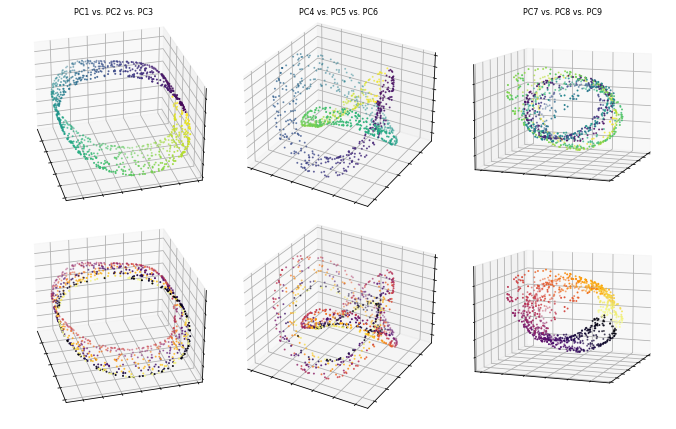

In [22]:
my_cmap = 'viridis'
fig = plt.figure(figsize=(9.5,7))

ax = fig.add_subplot(231, projection='3d')
ax.scatter(zeta[:,0], zeta[:,1], zeta[:,2],  marker='o', c=color_t1, s=1, cmap=my_cmap) #c=color,
ax.azim=-15
ax.set_title('PC1 vs. PC2 vs. PC3', pad=-8, fontsize=8)
ax.tick_params(labelbottom=False, labelleft=False)
#ax.set_xlabel('PC1', fontsize=6)
#ax.set_ylabel('PC2')
#ax.set_zlabel('PC3')
ax.zaxis.set_tick_params(labelsize=6)

ax = fig.add_subplot(232, projection='3d')
ax.scatter(zeta[:,3], zeta[:,4], zeta[:,5], marker='o', c=color_t1, s=1, cmap=my_cmap)
ax.set_title('PC4 vs. PC5 vs. PC6', pad=-8, fontsize=8)
ax.tick_params(labelbottom=False, labelleft=False)
#ax.set_xlabel('PC4')
#ax.set_ylabel('PC5')
#ax.set_zlabel('PC6')

ax = fig.add_subplot(233, projection='3d')
ax.scatter(zeta[:,6], zeta[:,7], zeta[:,8], marker='o', c=color_t1, s=1, cmap=my_cmap)
ax.azim=20
ax.elev = 10
ax.set_title('PC7 vs. PC8 vs. PC9', pad=-8, fontsize=8)
ax.tick_params(labelbottom=False, labelleft=False)
#ax.set_xlabel('PC7')
#ax.set_ylabel('PC8')
#ax.set_zlabel('PC9')

my_cmap = 'inferno'

ax = fig.add_subplot(234, projection='3d')
ax.scatter(zeta[:,0], zeta[:,1], zeta[:,2],  marker='o', c=-color_t2, s=1, cmap=my_cmap) #c=color,
ax.azim=-15
ax.tick_params(labelbottom=False, labelleft=False)
#ax.set_xlabel('PC1')
#ax.set_ylabel('PC2')
#ax.set_zlabel('PC3')

ax = fig.add_subplot(235, projection='3d')
ax.scatter(zeta[:,3], zeta[:,4], zeta[:,5], marker='o', c=-color_t2, s=1, cmap=my_cmap)
ax.tick_params(labelbottom=False, labelleft=False)
#ax.set_xlabel('PC4')
#ax.set_ylabel('PC5')
#ax.set_zlabel('PC6')

ax = fig.add_subplot(236, projection='3d')
ax.scatter(zeta[:,6], zeta[:,7], zeta[:,8], marker='o', c=-color_t2, s=1, cmap=my_cmap)
ax.azim=20
ax.elev = 10
ax.tick_params(labelbottom=False, labelleft=False)
#ax.set_xlabel('PC7')
#ax.set_ylabel('PC8')
#ax.set_zlabel('PC9')
#ax.axis('off')

#plt.subplots_adjust( wspace=0.25 )
#
fig.tight_layout()
plt.subplots_adjust( hspace=-0.28 )

In [69]:
# plt.savefig('torus_embedding.png', bbox_inches=matplotlib.transforms.Bbox([[0.3, 0.6], [9.3, 6.5]]), pad_inches=0, format='png', dpi=600)

<StemContainer object of 3 artists>

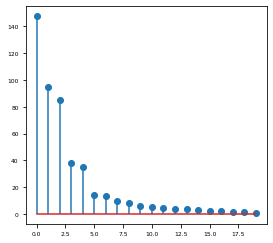

In [23]:
fig = plt.figure(figsize=(9.5,4))
#ax = fig.add_subplot(121)
#c = ax.imshow(K, cmap='hot', interpolation='nearest')

#fig.colorbar(c, ax=ax)
ax = fig.add_subplot(122)
ax.stem(s[0:r]**2/n)

## TDA

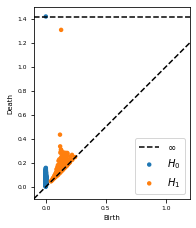

In [24]:
fig = plt.figure(figsize=(9.5,4))

diagrams_Z = ripser(Z, maxdim=1)['dgms']
#diagrams = ripser(Z, maxdim=2)['dgms'] #to include H_2 - very slow
plot_diagrams(diagrams_Z, show=True, ax=plt.subplot(131), xy_range=[-0.1,1.2,-0.1, 1.5])

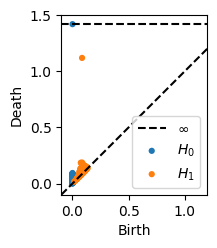

In [25]:
diagrams_zeta_partial = ripser(zeta[:,0:6], maxdim=1)['dgms']
plot_diagrams(diagrams_zeta_partial, show=True, ax=plt.subplot(132), xy_range=[-0.1,1.2,-0.1, 1.5])

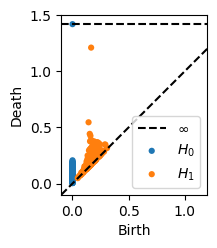

In [26]:
diagrams_zeta_full = ripser(zeta[:,0:r], maxdim=1)['dgms']
plot_diagrams(diagrams_zeta_full, show=True, ax=plt.subplot(133), xy_range=[-0.1,1.2,-0.1, 1.5])
fig.tight_layout()

In [27]:
# ## save for persistence diagrams in R
# tda_Z_H0 = diagrams_Z[0]
# tda_Z_H1 = diagrams_Z[1]

# tda_PC_d3_H0 = diagrams_zeta_partial[0]
# tda_PC_d3_H1 = diagrams_zeta_partial[1]

# tda_PC_d20_H0 = diagrams_zeta_full[0]
# tda_PC_d20_H1 = diagrams_zeta_full[1]

# np.savetxt('tda_Z_H0.dat', tda_Z_H0)
# np.savetxt('tda_Z_H1.dat', tda_Z_H1)

# np.savetxt('tda_PC_d3_H0.dat', tda_PC_d3_H0)
# np.savetxt('tda_PC_d3_H1.dat', tda_PC_d3_H1)

# np.savetxt('tda_PC_d20_H0.dat', tda_PC_d20_H0)
# np.savetxt('tda_PC_d20_H1.dat', tda_PC_d20_H1)

In [126]:
# plt.subplot(131).get_legend().remove()
# plt.subplot(132).get_legend().remove()

In [113]:
# plt.savefig('torus_tda.png', bbox_inches='tight', pad_inches=0, format='png', dpi=600)

## geodesic distance

In [28]:
#compute the approximate geodesic distances in Z and M using 5nn graph

embedding = Isomap(n_components=3, n_neighbors=5)
_ = embedding.fit_transform(zeta)
dist_mat_M = embedding.dist_matrix_

embedding_Z = Isomap(n_components=3, n_neighbors=5)
_ = embedding_Z.fit_transform(Z)
dist_mat_Z = embedding_Z.dist_matrix_

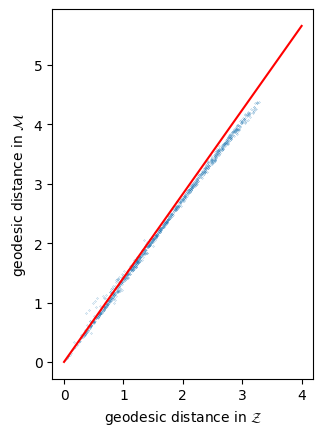

In [29]:
#plot geodesic distance in M against that in Z 

fig = plt.figure()

ax = fig.add_subplot(111)
ax.scatter(dist_mat_Z[np.triu_indices(n,k=1)][0:n], dist_mat_M[np.triu_indices(n,k=1)][0:n],  marker='.', s=0.1)

#for rbf kernel with gamma=1,H_z = 2 I for all z, and NB need to take square root: <x,H_z x>^1/2, hence sclaing factor of 2^1/2
ax.plot(np.array([0,4]),2**0.5*np.array([0,4]), color='r')
ax.set_xlabel('geodesic distance in $\mathcal{Z}$', fontsize=10)
ax.set_ylabel('geodesic distance in $\mathcal{M}$', fontsize=10)
plt.setp(ax.get_xticklabels(), fontsize=10)
plt.setp(ax.get_yticklabels(), fontsize=10)

ax.set_aspect('equal')

In [31]:
print(dist_mat_Z.shape)
print(dist_mat_Z[np.triu_indices(n,k=1)][0:200].shape)

(1000, 1000)
(200,)


In [32]:
#use seaborn to do a kde of the estimated geodesic distance estimates

import seaborn as sns

#Y = np.random.multivariate_normal((0, 0), [[0.8, 0.05], [0.05, 0.7]], 100)
kdeData = np.vstack((dist_mat_Z[np.triu_indices(n,k=1)][0:n],dist_mat_M[np.triu_indices(n,k=1)][0:n])).T
print(kdeData.shape)


(1000, 2)


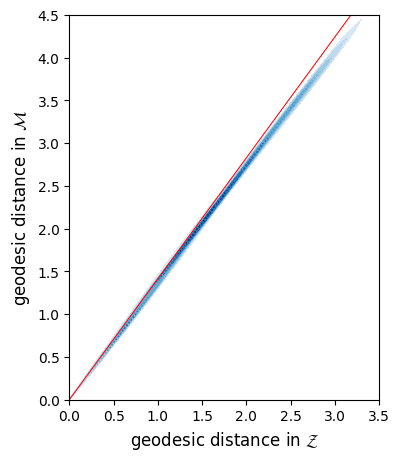

In [33]:
fig = plt.figure(figsize=(4,5))

ax = sns.kdeplot(x=kdeData[:,0],y=kdeData[:,1], shade = True, cmap = "Blues")
ax.patch.set_facecolor('white')
ax.collections[0].set_alpha(0)
#ax.set_xlabel('$Y_1$', fontsize = 15)
#ax.set_ylabel('$Y_0$', fontsize = 15)

ax.plot(np.array([0,3.5]),2**0.5*np.array([0,3.5]), color='r', linewidth=0.75)
ax.set_xlabel('geodesic distance in $\mathcal{Z}$',fontsize = 12)
ax.set_ylabel('geodesic distance in $\mathcal{M}$',fontsize = 12)
plt.setp(ax.get_xticklabels(), fontsize=10)
plt.setp(ax.get_yticklabels(), fontsize=10)
plt.xlim(0, 3.5)
plt.ylim(0, 4.5)
plt.show()
ax.set_aspect('equal')

In [34]:
import time
from sklearn.manifold import TSNE

In [35]:
time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=200, n_iter=500)
tsne_results = tsne.fit_transform(zeta)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/home/ag16115/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ag16115/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.091s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.506195
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.282303
[t-SNE] KL divergence after 500 iterations: 0.101384
t-SNE done! Time elapsed: 5.531407356262207 seconds


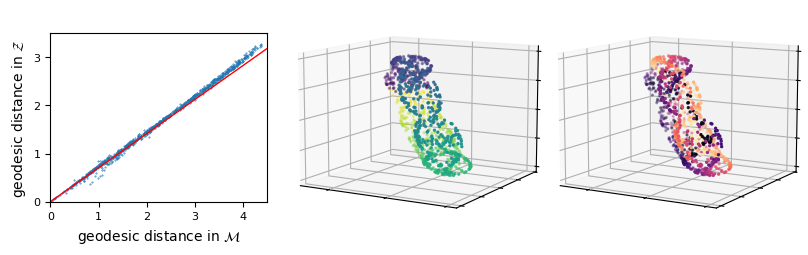

In [39]:
#fig = plt.figure()
fig = plt.figure(figsize=(9.5,3.5))


ax = fig.add_subplot(131)
ax.scatter(kdeData[:,1],kdeData[:,0], marker='.', s = 0.6)
ax.plot(np.array([0,4.5]),2**(-0.5)*np.array([0,4.5]), color='r', linewidth=1)
ax.set_xlabel('geodesic distance in $\mathcal{M}$',fontsize = 10)
ax.set_ylabel('geodesic distance in $\mathcal{Z}$',fontsize = 10)
plt.setp(ax.get_xticklabels(), fontsize=8)
plt.setp(ax.get_yticklabels(), fontsize=8)
plt.xlim(0, 4.5)
plt.ylim(0, 3.5)
ax.set_aspect('equal')

ax = fig.add_subplot(132, projection='3d')
ax.scatter(tsne_results[:,0],tsne_results[:,1],tsne_results[:,2],marker='o',c=color_t1, s=2, cmap='viridis')
ax.tick_params(labelbottom=False, labelleft=False)
ax.dist = 8
ax.elev = 10

ax = fig.add_subplot(133, projection='3d')
ax.scatter(tsne_results[:,0],tsne_results[:,1],tsne_results[:,2],marker='o',c=color_t2, s=2, cmap='magma')
ax.tick_params(labelbottom=False, labelleft=False)
ax.dist = 8
ax.elev = 10

In [124]:
# plt.savefig('torus_geodesic_dist.png',bbox_inches = 'tight', pad_inches=0, format='png', dpi=300)